In [77]:
%run Function_set_dic.ipynb

import networkx as nx
import numpy as np
from collections import defaultdict
import random
from numpy import random
import matplotlib.pyplot as plt
import json
import os
from tqdm.notebook import tqdm

In [78]:
from collections import defaultdict

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
import networkx as nx
import numpy as np
import dwave.inspector
import dimod
from dwave.system import LeapHybridSampler
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd

In [79]:
def test(network,pos):
    G, compelete_label, graph = complete_Graph(network,pos)
    G_prime, sub_edge_label, sub_graph = sub_Graph (network,pos)
    
    # How many panel ---> Max electricity level wire could reach 
    Q = len(pos)-1

    print(Q)

    # How many edges
    edge_number = len(compelete_label)

    # make dictionary
    edge_dictionary,Total = make_dictionary(edge_number, Q)

    # basic_cost shape => (1,number_of_edge)
    # such as : basic_cost = np.vstack(np.ones(number_of_edge))
    basic_cost = np.ones(edge_number)

    # flow cost (p)
    flow_cost = np.ones(edge_number)


    # initialize a QUBO matrix needed
    QUBO_matrix_initial = np.zeros((edge_number*Q,edge_number*Q))
    
    QUBO_Obj = Objective(Q, edge_number, edge_dictionary, QUBO_matrix_initial, basic_cost,flow_cost)

    penal = 5e1
    
    
    QUBO_Constraint_1 = Constraint_1(network, Q, edge_number, edge_dictionary, compelete_label, QUBO_matrix_initial, penalty = penal*12)

    QUBO_Constraint_2 = Constraint_2(network, Q, edge_number, edge_dictionary, compelete_label, QUBO_matrix_initial, penalty = penal*4)

    QUBO_Constraint_add = Constraint_add(network, Q, edge_number, compelete_label, edge_dictionary, QUBO_matrix_initial, penalty = penal*40 )   

    QUBO_matrix = QUBO_Obj + QUBO_Constraint_1 + QUBO_Constraint_2  + QUBO_Constraint_add


    QUBO = QUBO_matrix

    width,height = np.shape(QUBO)

    QUBO_dictionary = defaultdict(int)
    for i in range(width):
        for j in range(height):
            QUBO_dictionary[(i,j)] = QUBO[i,j]
    
    m_t_u,m_t_l = capacity_subtree_limit_generator(pos,Q)

    #print('m_t_l = ', m_t_l)
    m_t_u[:] = 0
    m_t_l[:] = 0
    #m_t_l[3] = 1
    m_t_l[2] = 1
    m_t_u[:] = 3

    #print('m_t_l = ', m_t_l)

    m_t_u = np.where(m_t_u < m_t_l, m_t_l, m_t_u)

    #print('m_t_u = ', m_t_u)


    QUBO_matrix_copy = QUBO_matrix

    QUBO_matrix_copy, QUBO_C3_p1, edge_dictionary_C31 = Constraint_3_part_1(network, m_t_u, Q, edge_number, edge_dictionary, QUBO_matrix_copy, penalty = penal)

    QUBO_matrix_copy, QUBO_C3_p2, edge_dictionary_C32 = Constraint_3_part_2(network, m_t_l, Q, edge_number, edge_dictionary_C31, QUBO_matrix_copy, penalty = penal)

    # Bus edge Ban map( Q ** 2)  可以通过就是 1 不可以就是 0
    Ban_map_Bus = np.ones( Q**2 )
    
    QUBO = QUBO_matrix_copy
    #QUBO = Final_QUBO_matrix
    #QUBO = QUBO_Obj + QUBO_Constraint_1 + QUBO_Constraint_2 + QUBO_Constraint_add

    width,height = np.shape(QUBO)

    QUBO_dictionary = defaultdict(int)
    for i in range(width):
        for j in range(height):
            QUBO_dictionary[(i,j)] = QUBO[i,j]


    # Select a solver
    sampler = LeapHybridSampler()

    sampleset = sampler.sample_qubo(QUBO)
    

    OP = sampleset.to_pandas_dataframe()


    OP = OP.sort_values("energy")
    OP_final = OP.to_numpy()

    rank = 0

    OP_opt = OP_final[rank,:].flatten()
    sample = OP_opt.astype(int)

    #sampleset.info['qpu_access_time']

    location = np.where(OP_opt[:-2])[0]

    number_of_edge = len(compelete_label)

    final_index = location[location < edge_number * Q ]


    final_G = nx.DiGraph()
    final_G = nx.from_numpy_array(np.zeros_like(network),create_using=nx.DiGraph(directed=True))


    for value in final_index:
        #print(str(value//Q))
        final_G.add_weighted_edges_from([(*edge, value % Q + 1) for edge, label in compelete_label.items() if label == str(value//Q)])

    matfig = plt.figure(i,figsize=(10,10)) 
    labels = nx.get_edge_attributes(final_G,'weight')
    widths = list(nx.get_edge_attributes(final_G,'weight').values())
    #print("widths",widths)
    nx.draw_networkx(final_G, pos)
    nx.draw_networkx_edge_labels(final_G,pos,edge_labels = labels)
    nx.draw_networkx_edges(final_G,pos,width = widths)
    
    time = [sampleset.info['qpu_access_time']*10**(-6), sampleset.info['charge_time']*10**(-6), sampleset.info['run_time']*10**(-6)]

    #Final_QUBO_matrix, QUBO_Constraint_4 = Constraint_4(QUBO_matrix, Q, Ban_map_Bus ,penalty = 1e2)
    return time

F:\UoH\UoH_code\Minimum Spanning Tree\Quantum\W4_H3_Benchmark
8
[[0.0, 2.993908, 2.993908]]


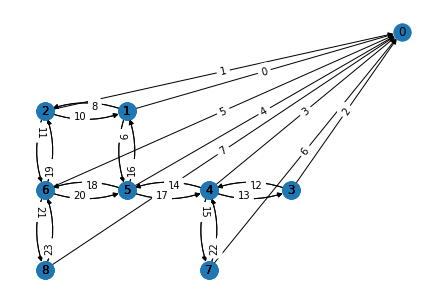

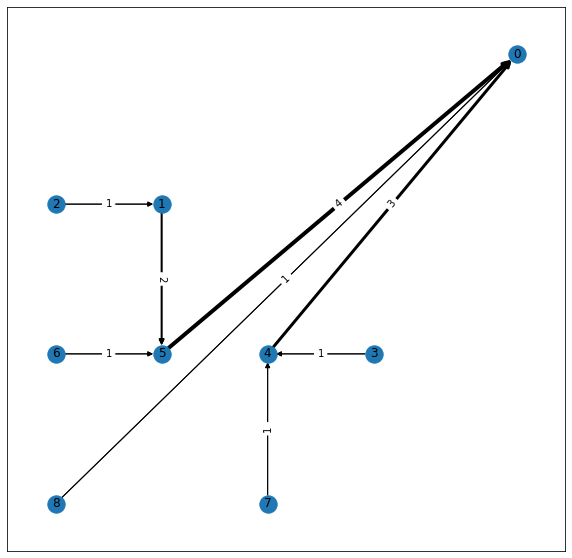

In [80]:
import time

bench_num = 10

Width = 4
Height = 3


current_directory = os.getcwd()
    
next_dir = "W%d_H%d_Benchmark"%(Width, Height)
    
final_directory = os.path.join(current_directory, next_dir)

time_list = []
    
print(final_directory)
    
if not os.path.exists(final_directory):
    os.makedirs(final_directory)


#for i in tqdm(range(bench_num)):  
#for i in tqdm(range(1)):  
i = 0

network = np.load("W%d_H%d_Benchmark/W%d_H%d_Benchmark%d.npy"%(Width, Height, Width, Height, i))
    
with open("W%d_H%d_Benchmark/W%d_H%d_Benchmark%d.json"%(Width, Height, Width, Height, i), 'r') as f:
    data = json.load(f)
    pos_convert = json.loads(data)
        
pos = {}
    
for key in pos_convert.keys():
    pos[int(key)] = tuple(pos_convert[key])

    
time_test = test(network,pos)
    
time_list.append(time_test)

print(time_list)


8
8
8
8
8
8
8
8
8
8



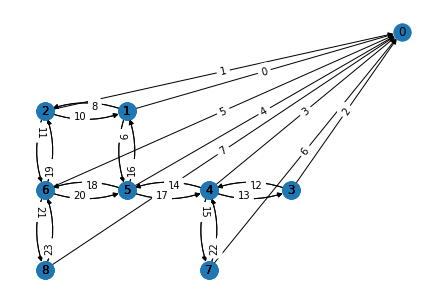

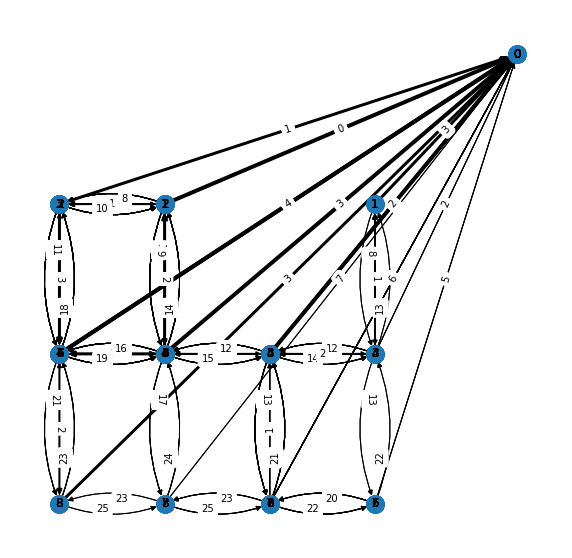

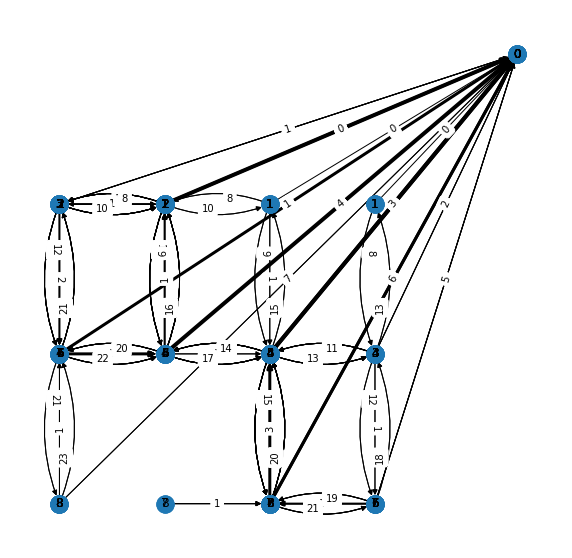

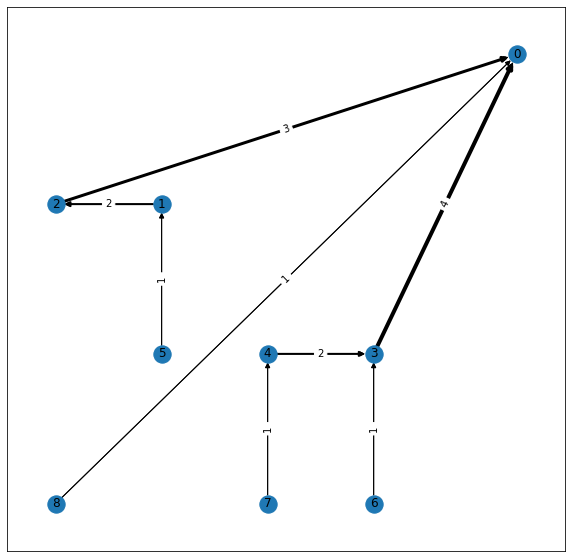

In [81]:

time_list = []
for i in tqdm(range(bench_num)):  
    #for i in tqdm(range(1)):  

    network = np.load("W%d_H%d_Benchmark/W%d_H%d_Benchmark%d.npy"%(Width, Height, Width, Height, i))

    with open("W%d_H%d_Benchmark/W%d_H%d_Benchmark%d.json"%(Width, Height, Width, Height, i), 'r') as f:
        data = json.load(f)
        pos_convert = json.loads(data)

    pos = {}

    for key in pos_convert.keys():
        pos[int(key)] = tuple(pos_convert[key])


    time_test = test(network,pos)

    time_list.append(time_test)
    
    time.sleep(1)
    

In [82]:
print(time_list)

[[0.0, 2.9868349999999997, 2.9868349999999997], [0.0, 2.992988, 2.992988], [0.0, 2.998574, 2.998574], [0.03451, 2.99471, 2.99471], [0.0, 2.988329, 2.988329], [0.0, 2.986572, 2.986572], [0.0, 2.9889069999999998, 2.9889069999999998], [0.0, 2.9962999999999997, 2.9962999999999997], [0.0, 2.971263, 2.971263], [0.034508, 2.988158, 2.988158]]


In [83]:
print(np.asarray(time_list))

[[0.       2.986835 2.986835]
 [0.       2.992988 2.992988]
 [0.       2.998574 2.998574]
 [0.03451  2.99471  2.99471 ]
 [0.       2.988329 2.988329]
 [0.       2.986572 2.986572]
 [0.       2.988907 2.988907]
 [0.       2.9963   2.9963  ]
 [0.       2.971263 2.971263]
 [0.034508 2.988158 2.988158]]


In [76]:
new_t_list = [
 [0.034505, 2.986137, 2.986137],
 [0.034579, 2.99566 , 2.99566 ],
 [0.034497, 2.989935, 2.989935],
 [0.034509, 2.99143 , 2.99143 ],
 [0.034421, 2.993751, 2.993751]]


optimal_sol_t = np.asarray(new_t_list)
#optimal_sol_t = np.asarray(time_list)

print(np.mean(optimal_sol_t,axis = 0))

[0.0345022 2.9913826 2.9913826]
